# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [77]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.|

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.280958
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [78]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.659005 analytic: 0.659005, relative error: 2.825430e-08
numerical: 1.831466 analytic: 1.831466, relative error: 2.103862e-11
numerical: 1.238341 analytic: 1.238341, relative error: 3.227400e-08
numerical: -4.342052 analytic: -4.342052, relative error: 2.515785e-08
numerical: 1.599395 analytic: 1.599395, relative error: 5.255375e-09
numerical: 1.232880 analytic: 1.232880, relative error: 5.057859e-08
numerical: -0.228723 analytic: -0.228723, relative error: 1.752634e-07
numerical: -0.792914 analytic: -0.792914, relative error: 1.617823e-09
numerical: 2.291664 analytic: 2.291664, relative error: 1.584222e-08
numerical: -0.484591 analytic: -0.484591, relative error: 3.383693e-08
numerical: -2.775105 analytic: -2.775105, relative error: 4.540493e-09
numerical: 2.354888 analytic: 2.354888, relative error: 2.320926e-08
numerical: 1.569817 analytic: 1.569817, relative error: 4.455204e-08
numerical: 0.517881 analytic: 0.517881, relative error: 7.721606e-08
numerical: -0.220497 ana

In [112]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.280958e+00 computed in 0.026998s
[[0.89901606 0.64605774 1.32703781 ... 1.03050174 0.66774076 1.09200515]
 [0.95362863 1.23110772 1.30079613 ... 1.33148837 1.05941466 0.84899129]
 [0.71361929 1.38383765 1.08821097 ... 0.49457717 0.69048662 0.87198205]
 ...
 [0.94807826 0.77478501 0.9489091  ... 0.90194784 0.73599032 1.0744626 ]
 [0.68460218 2.54583578 1.1674995  ... 0.94057492 1.32647558 1.47999446]
 [1.11932962 1.19350415 1.08330057 ... 1.61111355 0.90860274 1.13146638]]
vectorized loss: 2.280958e+00 computed in 0.003213s
Loss difference: 0.000000
Gradient difference: 0.000000


In [105]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))



iteration 0 / 1500: loss 387.257309
iteration 100 / 1500: loss 234.303619
iteration 200 / 1500: loss 142.473322
iteration 300 / 1500: loss 86.782440
iteration 400 / 1500: loss 53.424052
iteration 500 / 1500: loss 33.092740
iteration 600 / 1500: loss 20.828511
iteration 700 / 1500: loss 13.366358
iteration 800 / 1500: loss 8.902833
iteration 900 / 1500: loss 6.182165
iteration 1000 / 1500: loss 4.521171
iteration 1100 / 1500: loss 3.491750
iteration 1200 / 1500: loss 2.963483
iteration 1300 / 1500: loss 2.598776
iteration 1400 / 1500: loss 2.417417
That took 2.684040s


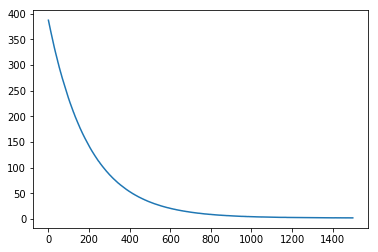

In [106]:
plt.plot(loss_hist)

----------Hyperparameter combination----------
learning_rate:  1e-07
reg:  25000.0
iteration 0 / 2000: loss 390.432142
iteration 100 / 2000: loss 235.476289
iteration 200 / 2000: loss 142.930749
iteration 300 / 2000: loss 87.271199
iteration 400 / 2000: loss 53.578418
iteration 500 / 2000: loss 33.219903
iteration 600 / 2000: loss 20.913204
iteration 700 / 2000: loss 13.461742
iteration 800 / 2000: loss 8.933862
iteration 900 / 2000: loss 6.176986
iteration 1000 / 2000: loss 4.570263
iteration 1100 / 2000: loss 3.554457
iteration 1200 / 2000: loss 2.983497
iteration 1300 / 2000: loss 2.628031
iteration 1400 / 2000: loss 2.288296
iteration 1500 / 2000: loss 2.235869
iteration 1600 / 2000: loss 2.113577
iteration 1700 / 2000: loss 2.078857
iteration 1800 / 2000: loss 2.069457
iteration 1900 / 2000: loss 2.021294
training accuracy: 0.351102
validation accuracy: 0.368000
----------Hyperparameter combination----------
learning_rate:  1e-07
reg:  50000.0
iteration 0 / 2000: loss 772.048927
i

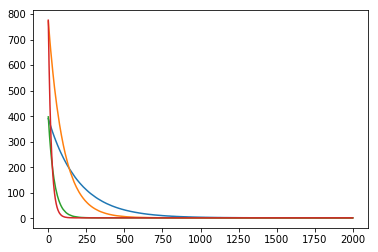

In [107]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        print("----------Hyperparameter combination----------")        
        print("learning_rate: ", learning_rate)
        print("reg: ",reg)
        
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate, reg, num_iters=2000, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % (train_acc, ))
        y_val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        if best_val < val_acc:
            best_val = val_acc
            best_softmax = softmax
        print('validation accuracy: %f' % (val_acc, ))
        results[(learning_rate, reg)] =  (train_acc, val_acc)
#         plt.plot(loss_hist)
        

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

In [108]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.360000


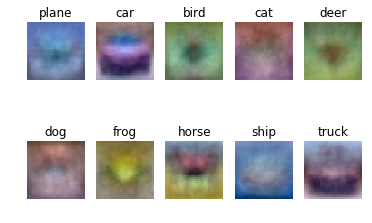

In [102]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])